In [1]:
import glob
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
# matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [8, 6]

DATA_DIR = r"D:\\data\\lc_data\\data\\"

PLOT_DIR = r"D:\\plots\\lc_pollutant\\plots\\"

In [2]:
def load_data(files, classification):
    best_file = ''
    best_ytrue = []
    best_ypred = []
    if classification == 0:
        best_metric = 100000
    else:
        best_metric = -100000
    for file in files:
        cv_files = sorted(glob.glob(file.split("v0")[0] + "v*.pickle"))
        cv_ytrue = []
        cv_ypred = []
        for cv_file in cv_files:
            with open(cv_file, 'rb') as handle:
                y_true = pickle.load(handle, errors='ignore')
                y_pred = pickle.load(handle, errors='ignore')
            if classification == 1:
                y_true = np.argmax(y_true, axis=1)
                y_pred = np.argmax(y_pred, axis=1)
            cv_ytrue.append(y_true)
            cv_ypred.append(y_pred)
        y_true = np.array(cv_ytrue).ravel()
        y_pred = np.array(cv_ypred).ravel()
        if classification == 0:
            metric = mean_squared_error(y_true, y_pred) ** 0.5
            if metric <= best_metric:
                best_metric = metric
                best_file = file
                best_ytrue = cv_ytrue
                best_ypred = cv_ypred
        else:
            metric = f1_score(y_true, y_pred, average='micro')
            if metric >= best_metric:
                best_metric = metric
                best_file = file
                best_ytrue = cv_ytrue
                best_ypred = cv_ypred
    best_file = best_file.split("\\")[-1].split("v0.pickle")[0]
    return best_metric, best_file, best_ytrue, best_ypred

In [3]:
def load_results():
    data = []
    for rgb in [0, 1]:
        data_r = []
        for ozone in [0, 1]:
            data_o = []
            for classification in [0, 1]:
                data_c = []
                if ozone == 0:
                    concs = ["1.5", "5.0", "100.0", "650.0"]
                else:
                    concs = ["0.0", "1.0", "2.0", "5.0"]
                for conc in concs:
                    files = sorted(
                        glob.glob(
                            DATA_DIR + "e*b*l*f*d*c{}t*o{}x{}a*r{}v0.pickle".format(conc, ozone, classification, rgb)))
                    best_metric, best_file, best_ytrue, best_ypred = load_data(files, classification)
                    data_c.append([best_ytrue, best_ypred])
                data_o.append(data_c)
            data_r.append(data_o)
        data.append(data_r)
    return data

In [4]:
data = load_results()

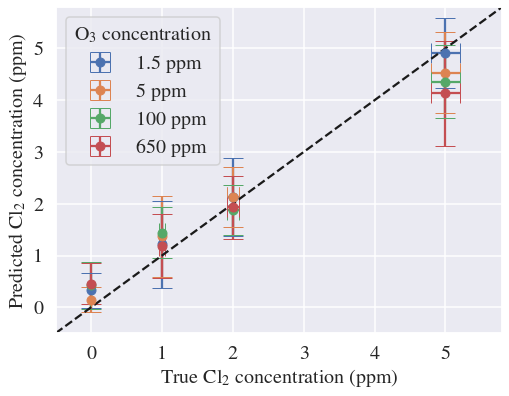

In [5]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = ["1.5 ppm", "5 ppm", "100 ppm", "650 ppm"]
# xmove = [-0.15, -0.05, 0.05, 0.15] if want to separate a litte bit
xmove = [0, 0, 0, 0]
cl2_err = [0, 0.04, 0.08, 0.20]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][0][0][i][0])
    y_pred = np.concatenate(data[1][0][0][i][1])
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    y_unique = sorted(np.unique(y_true))
    result = np.zeros(shape=(4, 4))
    for j in range(len(y_unique)):
        y = y_unique[j]
        index = np.where(y_true == y)[0]
        mean = np.mean(y_pred[index])
        std = np.std(y_pred[index])
        result[j, 0] = y
        result[j, 1] = mean
        result[j, 2] = std
        result[j, 3] = cl2_err[j]
    plt.errorbar(x=result[:, 0]+xmove[i], y=result[:, 1], yerr=result[:, 2], xerr=result[:, 3], capsize=10, fmt='o', label=labels[i])
plt.plot([-0.5, 5.8], [-0.5, 5.8], 'k--')
plt.xlim([-0.5, 5.8])
plt.ylim([-0.5, 5.8])
plt.legend(title=r"O$_3$ concentration")
plt.xlabel(r"True Cl$_2$ concentration (ppm)")
plt.ylabel(r"Predicted Cl$_2$ concentration (ppm)")
plt.savefig(PLOT_DIR + "fix_ozone_regression.png", dpi=300)

In [26]:
from sklearn.metrics import r2_score, mean_squared_error
for i in range(4):
    y_true = np.concatenate(data[1][0][0][i][0]).ravel()
    y_pred = np.concatenate(data[1][0][0][i][1]).ravel()
    r2 = r2_score(y_pred=y_pred, y_true=y_true)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true) ** 0.5
    print(f"O3 {labels[i]} R2 score is {r2:0.4f}.")
    print(f"O3 {labels[i]} RMSE is {rmse:0.4f}.")

O3 1.5 ppm R2 score is 0.8408.
O3 1.5 ppm RMSE is 0.7187.
O3 5 ppm R2 score is 0.8612.
O3 5 ppm RMSE is 0.6983.
O3 100 ppm R2 score is 0.8706.
O3 100 ppm RMSE is 0.7260.
O3 650 ppm R2 score is 0.7866.
O3 650 ppm RMSE is 0.8711.


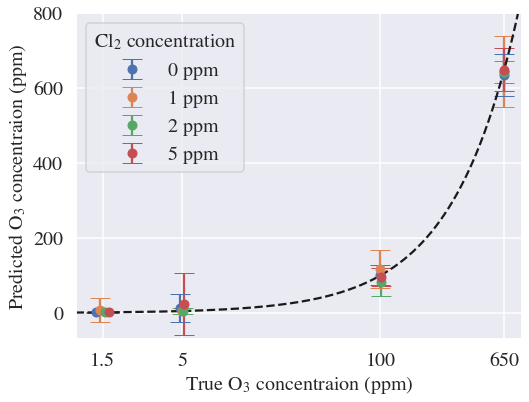

In [6]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = ["0 ppm", "1 ppm", "2 ppm", "5 ppm"]
xmove = [-0.15, -0.05, 0.05, 0.15]
xticks = [1.5, 5, 100, 650]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][1][0][i][0])
    y_pred = np.concatenate(data[1][1][0][i][1])
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    y_unique = sorted(np.unique(y_true))
    result = np.zeros(shape=(4, 3))
    for j in range(len(y_unique)):
        y = y_unique[j]
        index = np.where(y_true == y)[0]
        mean = np.mean(y_pred[index])
        std = np.std(y_pred[index])
        result[j, 0] = y
        result[j, 1] = mean
        result[j, 2] = std
    plt.errorbar(x=result[:, 0]+xmove[i], y=result[:, 1], yerr=result[:, 2], capsize=10, fmt='o', label=labels[i])
plt.plot(np.linspace(1, 850, 1000), np.linspace(1, 850, 1000), 'k--')
plt.xlim([1, 850])
plt.ylim([-70, 800])
plt.legend(title=r"Cl$_2$ concentration")
plt.xlabel(r"True O$_3$ concentraion (ppm)")
plt.ylabel(r"Predicted O$_3$ concentraion (ppm)")
plt.xscale("log")
plt.xticks(xticks, xticks)
plt.savefig(PLOT_DIR + "fix_chlorine_regression.png", dpi=300)

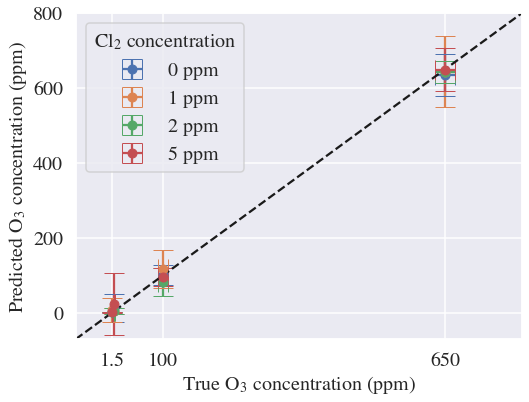

In [6]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = ["0 ppm", "1 ppm", "2 ppm", "5 ppm"]
# xmove = [-0.15, -0.05, 0.05, 0.15] if want to separate a litte bit
xmove = [0, 0, 0, 0]
xticks = [1.5, 100, 650]
o3_err = [0.2, 1, 10, 20]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][1][0][i][0])
    y_pred = np.concatenate(data[1][1][0][i][1])
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    y_unique = sorted(np.unique(y_true))
    result = np.zeros(shape=(4, 4))
    for j in range(len(y_unique)):
        y = y_unique[j]
        index = np.where(y_true == y)[0]
        mean = np.mean(y_pred[index])
        std = np.std(y_pred[index])
        result[j, 0] = y
        result[j, 1] = mean
        result[j, 2] = std
        result[j, 3] = o3_err[j]
    plt.errorbar(x=result[:, 0]+xmove[i], y=result[:, 1], yerr=result[:, 2], xerr=result[:, 3], capsize=10, fmt='o', label=labels[i])
plt.plot(np.linspace(-70, 800, 1000), np.linspace(-70, 800, 1000), 'k--')
plt.xlim([-70, 800])
plt.ylim([-70, 800])
plt.legend(title=r"Cl$_2$ concentration")
plt.xlabel(r"True O$_3$ concentration (ppm)")
plt.ylabel(r"Predicted O$_3$ concentration (ppm)")
plt.xticks(xticks, xticks)
plt.savefig(PLOT_DIR + "fix_chlorine_regression_linear.png", dpi=300)

In [23]:
from sklearn.metrics import r2_score, mean_squared_error
for i in range(4):
    y_true = np.concatenate(data[1][1][0][i][0]).ravel()
    y_pred = np.concatenate(data[1][1][0][i][1]).ravel()
    r2 = r2_score(y_pred=y_pred, y_true=y_true)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true) ** 0.5
    print(f"Cl2 {labels[i]} R2 score is {r2:0.4f}.")
    print(f"Cl2 {labels[i]} RMSE is {rmse:0.4f}.")

Cl2 0 ppm R2 score is 0.9794.
Cl2 0 ppm RMSE is 44.1054.
Cl2 1 ppm R2 score is 0.9499.
Cl2 1 ppm RMSE is 69.8342.
Cl2 2 ppm R2 score is 0.9925.
Cl2 2 ppm RMSE is 26.8809.
Cl2 5 ppm R2 score is 0.9704.
Cl2 5 ppm RMSE is 52.5872.


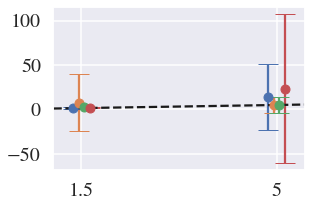

In [89]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = ["0 ppm", "1 ppm", "2 ppm", "5 ppm"]
xmove = [-0.15, -0.05, 0.05, 0.15]
xticks = [1.5, 5]
plt.figure(figsize=(4.5, 3))
for i in range(4):
    y_true = np.concatenate(data[1][1][0][i][0])
    y_pred = np.concatenate(data[1][1][0][i][1])
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    y_unique = sorted(np.unique(y_true))
    result = np.zeros(shape=(2, 3))
    for j in range(2):
        y = y_unique[j]
        index = np.where(y_true == y)[0]
        mean = np.mean(y_pred[index])
        std = np.std(y_pred[index])
        result[j, 0] = y
        result[j, 1] = mean
        result[j, 2] = std
    plt.errorbar(x=result[:, 0]+xmove[i], y=result[:, 1], yerr=result[:, 2], capsize=10, fmt='o', label=labels[i])
plt.plot(np.linspace(1.0, 5.5, 100), np.linspace(1.0, 5.5, 100), 'k--')
plt.xlim([1.0, 5.5])
plt.locator_params(axis='y', nbins=4)
plt.xticks(xticks, xticks)
plt.savefig(PLOT_DIR + "fix_chlorine_regression_linear_zoomin.png", dpi=300, transparent=False, bbox_inches="tight")

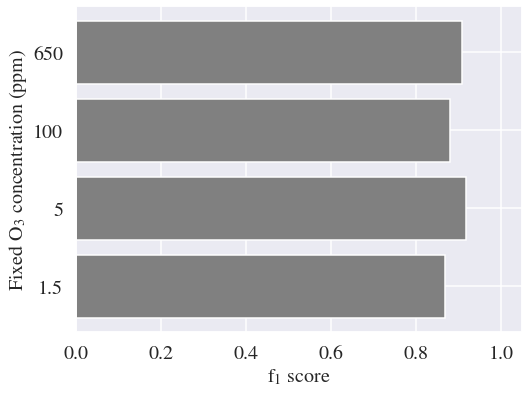

In [7]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = [1.5, 5, 100, 650]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][0][1][i][0])
    y_pred = np.concatenate(data[1][0][1][i][1])
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    plt.barh(i, f1, color="gray")
plt.yticks(range(4), labels)
plt.ylabel(r"Fixed O$_3$ concentration (ppm)")
plt.xlabel(r"f$_1$ score")
plt.xlim([0, 1.05])
plt.savefig(PLOT_DIR + "fix_ozone_classification.png", dpi=300)

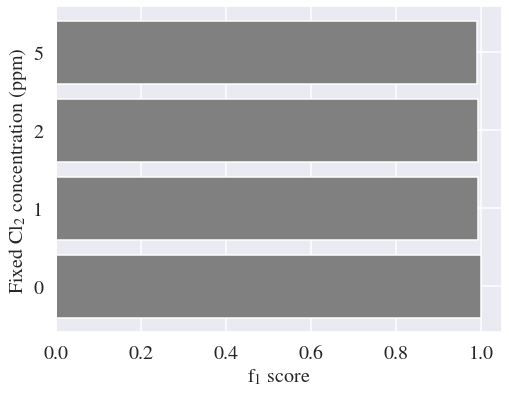

In [8]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = [0, 1, 2, 5]
plt.figure()
for i in range(4):
    y_true = np.concatenate(data[1][1][1][i][0])
    y_pred = np.concatenate(data[1][1][1][i][1])
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    plt.barh(i, f1, color="gray")
plt.yticks(range(4), labels)
plt.ylabel(r"Fixed Cl$_2$ concentration (ppm)")
plt.xlabel(r"f$_1$ score")
plt.xlim([0, 1.05])
plt.savefig(PLOT_DIR + "fix_chlorine_classification.png", dpi=300)

In [39]:
# matplotlib.rcParams.keys()

In [5]:
data2ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-1-2ppm Cl2 with different O3")

In [6]:
data650ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-2-650ppm O3 mixtures")

In [7]:
data100ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-3-100ppm O3 mixtures")

In [8]:
data5ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-4-5ppm O3 mixtures")

In [9]:
data15ppm = pd.read_excel(DATA_DIR+"Normalized_light_intensity.xlsx", sheet_name=R"SI-5-1.5ppm O3 mixtures")

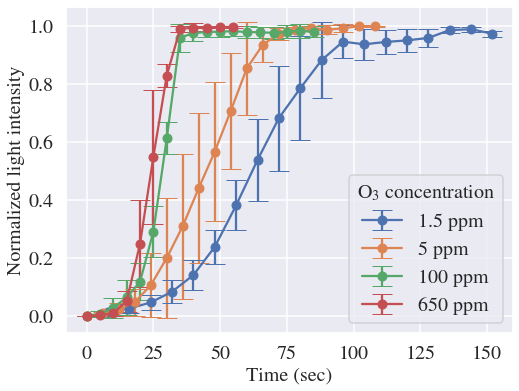

In [10]:
data2ppm650 = data2ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data2ppm100 = data2ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data2ppm5 = data2ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data2ppm15 = data2ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data2ppm15[:, 0], y=data2ppm15[:, 1], yerr=data2ppm15[:, 2], capsize=10, fmt='o-', label="1.5 ppm")
plt.errorbar(x=data2ppm5[:, 0], y=data2ppm5[:, 1], yerr=data2ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.errorbar(x=data2ppm100[:, 0], y=data2ppm100[:, 1], yerr=data2ppm100[:, 2], capsize=10, fmt='o-', label="100 ppm")
plt.errorbar(x=data2ppm650[:, 0], y=data2ppm650[:, 1], yerr=data2ppm650[:, 2], capsize=10, fmt='o-', label="650 ppm")
plt.legend(title=r"O$_3$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")
plt.savefig(PLOT_DIR + "chlorine2.png", dpi=300)

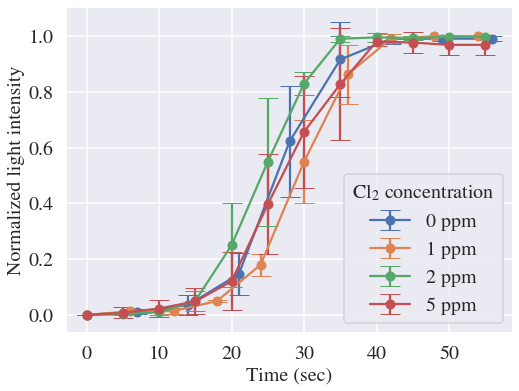

In [46]:
data650ppm0 = data650ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data650ppm1 = data650ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data650ppm2 = data650ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data650ppm5 = data650ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data650ppm0[:, 0], y=data650ppm0[:, 1], yerr=data650ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data650ppm1[:, 0], y=data650ppm1[:, 1], yerr=data650ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data650ppm2[:, 0], y=data650ppm2[:, 1], yerr=data650ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data650ppm5[:, 0], y=data650ppm5[:, 1], yerr=data650ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")
plt.savefig(PLOT_DIR + "ozone650.png", dpi=300)

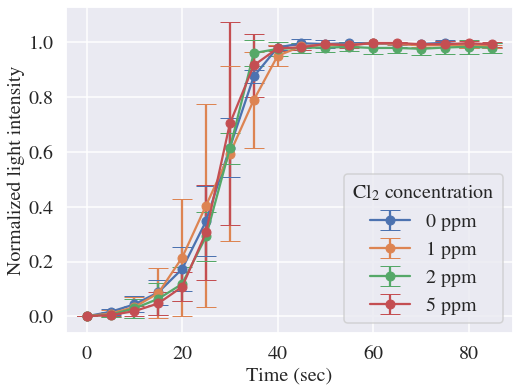

In [11]:
data100ppm0 = data100ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data100ppm1 = data100ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data100ppm2 = data100ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data100ppm5 = data100ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data100ppm0[:, 0], y=data100ppm0[:, 1], yerr=data100ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data100ppm1[:, 0], y=data100ppm1[:, 1], yerr=data100ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data100ppm2[:, 0], y=data100ppm2[:, 1], yerr=data100ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data100ppm5[:, 0], y=data100ppm5[:, 1], yerr=data100ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")
plt.savefig(PLOT_DIR + "ozone100.png", dpi=300)

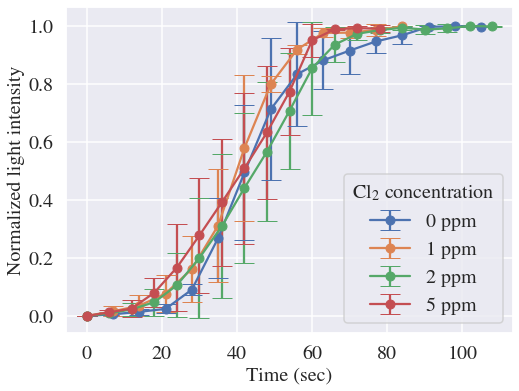

In [48]:
data5ppm0 = data5ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data5ppm1 = data5ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data5ppm2 = data5ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data5ppm5 = data5ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data5ppm0[:, 0], y=data5ppm0[:, 1], yerr=data5ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data5ppm1[:, 0], y=data5ppm1[:, 1], yerr=data5ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data5ppm2[:, 0], y=data5ppm2[:, 1], yerr=data5ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data5ppm5[:, 0], y=data5ppm5[:, 1], yerr=data5ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")
plt.savefig(PLOT_DIR + "ozone5.png", dpi=300)

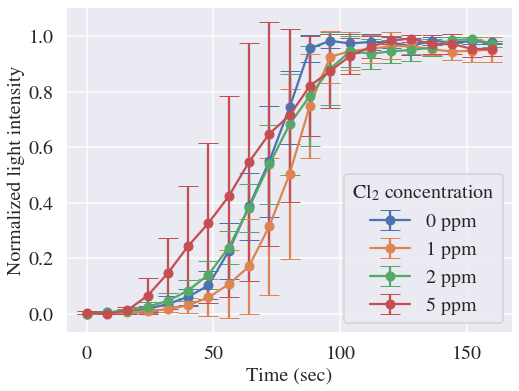

In [49]:
data15ppm0 = data15ppm.iloc[2:, :3].dropna().values.squeeze().astype(np.float32)
data15ppm1 = data15ppm.iloc[2:, 4:7].dropna().values.squeeze().astype(np.float32)
data15ppm2 = data15ppm.iloc[2:, 8:11].dropna().values.squeeze().astype(np.float32)
data15ppm5 = data15ppm.iloc[2:, 12:15].dropna().values.squeeze().astype(np.float32)
plt.figure()
plt.errorbar(x=data15ppm0[:, 0], y=data15ppm0[:, 1], yerr=data15ppm0[:, 2], capsize=10, fmt='o-', label="0 ppm")
plt.errorbar(x=data15ppm1[:, 0], y=data15ppm1[:, 1], yerr=data15ppm1[:, 2], capsize=10, fmt='o-', label="1 ppm")
plt.errorbar(x=data15ppm2[:, 0], y=data15ppm2[:, 1], yerr=data15ppm2[:, 2], capsize=10, fmt='o-', label="2 ppm")
plt.errorbar(x=data15ppm5[:, 0], y=data15ppm5[:, 1], yerr=data15ppm5[:, 2], capsize=10, fmt='o-', label="5 ppm")
plt.legend(title=r"Cl$_2$ concentration", loc="lower right")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized light intensity")
plt.savefig(PLOT_DIR + "ozone1p5.png", dpi=300)

# Figure 3

In [35]:
DATA_DIR = r"D:\\data\\lc_data\\chtccl2\\results\\"

files = glob.glob(DATA_DIR + "O3Cl2_*_{}_{}_*_3.pickle".format(5.0, 5.0))
time = []
for i, file in enumerate(files):
    with open(file, "rb") as handle:
        _ = pickle.load(handle)  # space
        time.append(pickle.load(handle))  # time

time = np.abs(np.array(time))  # 13*150*3
red = time[..., 0]
green = time[..., 1]
blue = time[..., 2]

mean_red = red.mean(axis=0)
mean_green = green.mean(axis=0)
mean_blue = blue.mean(axis=0)

std_red = red.std(axis=0)
std_green = red.std(axis=0)
std_blue = red.std(axis=0)

normalized_max = mean_green.max()

mean_red /= normalized_max
mean_green /= normalized_max
mean_blue /= normalized_max

std_red /= normalized_max
std_green /= normalized_max
std_blue /= normalized_max

x = np.linspace(0, len(mean_red)/2, len(mean_red))

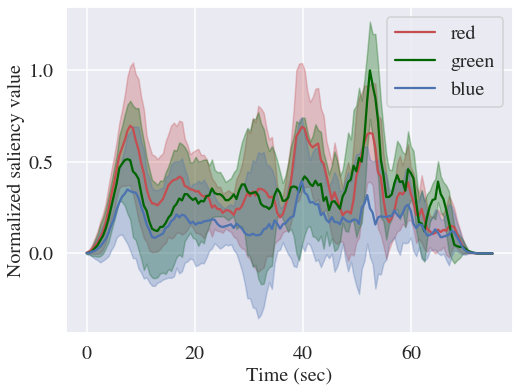

In [36]:
plt.figure()
plt.plot(x, mean_red, c="r", label="red")
plt.plot(x, mean_green, c="darkgreen", label="green")
plt.plot(x, mean_blue, c="b", label="blue")
plt.fill_between(x, mean_red - std_red, mean_red + std_red, alpha=0.3, color="r")
plt.fill_between(x, mean_green - std_green, mean_green + std_green, alpha=0.3, color="darkgreen")
plt.fill_between(x, mean_blue - std_blue, mean_blue + std_blue, alpha=0.3, color="b")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized saliency value")
plt.legend()
plt.locator_params(axis='y', nbins=4)
plt.savefig(PLOT_DIR + "o5c5saliencytime.png", dpi=300)

In [91]:
from skimage.color import rgb2lab
DATA_DIR = r"D:\\data\\lc_data\\chtccl2\\results\\"
RAW_DATA_DIR = r"F:\\O3Cl2_3DCNN\\"
A_DATA_DIR = r"F:\\O3Cl2_ASTAR\\"
file = glob.glob(DATA_DIR + "O3Cl2_605_{}_{}_7_3.pickle".format("*", "*"))[0]
raw_file = glob.glob(RAW_DATA_DIR + "O3Cl2_605_{}_{}_7_3.h5".format("*", "*"))[0]
a_file = glob.glob(A_DATA_DIR + "O3Cl2_605_{}_{}_7_3.h5".format("*", "*"))[0]

with open(file, "rb") as handle:
    space0 = pickle.load(handle)  # space
    time0 = np.abs(pickle.load(handle))  # time
    
with h5py.File(raw_file, "r") as handle:
    intensity = handle['x']
    intensity0 = np.array(intensity)
    handle.close()

astar0 = rgb2lab(intensity0)

In [92]:
time = np.mean(time0, axis=-1)
intensity = np.mean(intensity0, axis=(1, 2, 3))
astar = np.mean(astar0[..., 1], axis=(1, 2))

time -= time.min()
intensity -= intensity.min()
astar -= astar.min()
time /= time.max()
intensity /= intensity.max()
astar /= astar.max()

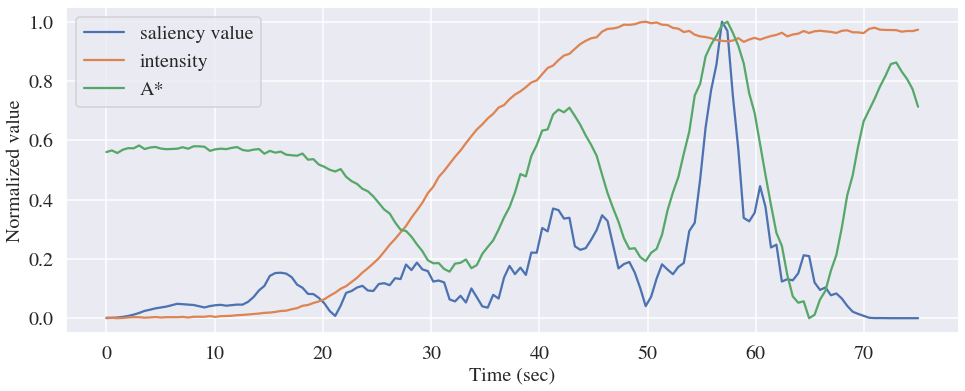

In [94]:
plt.figure(figsize=(16, 6))
plt.plot(x, time, label="saliency value")
plt.plot(x, intensity, label="intensity")
plt.plot(x, astar, label="A*")
plt.xlabel(r"Time (sec)")
plt.ylabel(r"Normalized value")
plt.legend()
plt.savefig(PLOT_DIR + "605o5c2grid7saliencytime.png", dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


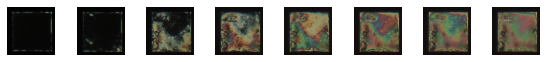

In [97]:
fig, axes = plt.subplots(1, 8, figsize=(8, 2))
time_list = [0, 40, 66, 84, 100, 114, 124, 149]
for i, time in enumerate(time_list):
    axes[i].imshow(intensity0[time])
for axis in axes:
    axis.axis(False)
plt.tight_layout()
plt.savefig(PLOT_DIR + "605o5c2grid7rgb.png", dpi=300, transparent=True)

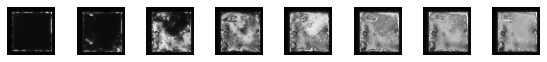

In [98]:
fig, axes = plt.subplots(1, 8, figsize=(8, 2))
for i, time in enumerate(time_list):
    axes[i].imshow(intensity0[time].mean(axis=-1), cmap="gray")
for axis in axes:
    axis.axis(False)
plt.tight_layout()
plt.savefig(PLOT_DIR + "605o5c2grid7gray.png", dpi=300, transparent=True)

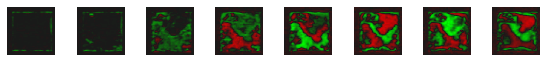

In [99]:
colorsList = [(0.0, 1.0, 0.0), (0.1, 0.1, 0.1), (1.0, 0.0, 0.0)]
CustomCmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom', colorsList, N=200)

ref = 25
fig, axes = plt.subplots(1, 8, figsize=(8, 2))
for i, time in enumerate(time_list):
    axes[i].imshow(astar0[time, ..., 1], cmap=CustomCmap, vmin=-ref, vmax=ref)
for axis in axes:
    axis.axis(False)
plt.tight_layout()
plt.savefig(PLOT_DIR + "605o5c2grid7astar.png", dpi=300, transparent=True)

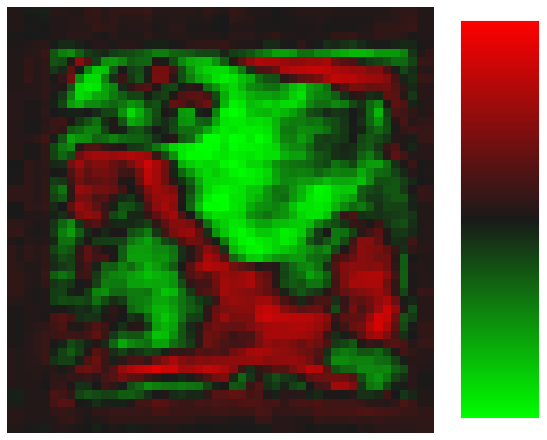

In [85]:
colorsList = [(0.0, 1.0, 0.0), (0.1, 0.1, 0.1), (1.0, 0.0, 0.0)]
CustomCmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom', colorsList, N=200)

ref = 25
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
im = axes.imshow(astar0[124, ..., 1], cmap=CustomCmap, vmin=-ref, vmax=ref)
cbar = plt.colorbar(im, aspect=5)
cbar.set_ticks([])
axes.axis("off")
plt.tight_layout()
plt.savefig(PLOT_DIR + "605o5c2grid7astar_colorbar.png", dpi=300, transparent=True)

# Figure Dataflow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


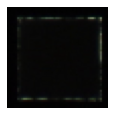

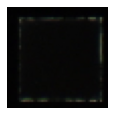

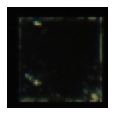

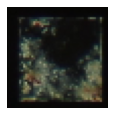

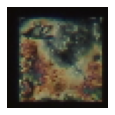

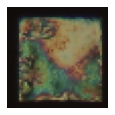

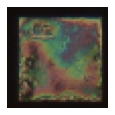

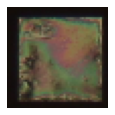

In [196]:
for i in [0, 20, 40, 60, 80, 100, 120, 140]:
    fig, axs = plt.subplots(1, 1, figsize=(2, 2))
    axs.imshow(intensity0[i])
    axs.axis(False)
    plt.tight_layout()
    plt.savefig(PLOT_DIR + "605o5c2grid7rgb{}.png".format(i), dpi=300, transparent=True)

In [ ]:
# 1 rgb 2 ozone 3 classification 4 concs 5 best_ytrue
labels = ["1.5 ppm", "5 ppm", "100 ppm", "650 ppm"]
xmove = [-0.15, -0.05, 0.05, 0.15]
plt.figure()
for i in range(1):
    y_true = np.concatenate(data[1][0][0][i][0])
    y_pred = np.concatenate(data[1][0][0][i][1])
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    y_unique = sorted(np.unique(y_true))
    result = np.zeros(shape=(4, 3))
    for j in range(len(y_unique)):
        y = y_unique[j]
        index = np.where(y_true == y)[0]
        mean = np.mean(y_pred[index])
        std = np.std(y_pred[index])
        result[j, 0] = y
        result[j, 1] = mean
        result[j, 2] = std
    plt.errorbar(x=result[:, 0]+xmove[i], y=result[:, 1], yerr=result[:, 2], capsize=10, fmt='o', label=labels[i])
plt.plot([-0.5, 5.8], [-0.5, 5.8], 'k--')
plt.xlim([-0.5, 5.8])
plt.ylim([-0.5, 5.8])
plt.legend(title=r"O$_3$ concentration")
plt.xlabel(r"True Cl$_2$ concentraion (ppm)")
plt.ylabel(r"Predicted Cl$_2$ concentraion (ppm)")
plt.savefig(PLOT_DIR + "fix_ozone_regression.png", dpi=300)